By: Lincoln Schafer

As there is no findable database of per game player statistics for the MLB, we decided to attempt to compare team performance at altitude vs not at altitude.  Present is data for teams that played in Denver for every year that there has been an MLB team there, as well as the visiting teams' home statistics.

In [5]:
pip install --upgrade https://storage.googleapis.com/tensorflow/linux/cpu/tensorflow_cpu-2.7.0-cp39-cp39-manylinux2010_x86_64.whl


     |████████████████████████████████| 179.9 MB 3.5 kB/s             
     |████████████████████████████████| 1.3 MB 19.1 MB/s            
     |████████████████████████████████| 65 kB 5.1 MB/s             
     |████████████████████████████████| 463 kB 69.4 MB/s            
     |████████████████████████████████| 5.8 MB 28.8 MB/s            
     |████████████████████████████████| 57 kB 6.7 MB/s             
     |████████████████████████████████| 13.4 MB 24.3 MB/s            
     |████████████████████████████████| 2.1 MB 46.3 MB/s            
     |████████████████████████████████| 155 kB 66.8 MB/s            
     |████████████████████████████████| 781 kB 45.9 MB/s            
     |████████████████████████████████| 4.9 MB 53.0 MB/s            
     |████████████████████████████████| 155 kB 68.2 MB/s            
     |████████████████████████████████| 77 kB 8.5 MB/s             
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 1.12.2
    Uninstallin

In [4]:
import sys

In [ ]:
!conda install --yes --prefix {sys.prefix} pandasql

In [1]:
#Importing necessary libraries
import sys
import pandas as p #dataframes to hold tables
from pandasql import sqldf #sql to dataframe conversion for data access
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import warnings
import os
import subprocess
from sklearn.model_selection import train_test_split #method to split dataframe into train and test sets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, Normalizer
from sklearn.decomposition import PCA as sklearnPCA
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn import svm, metrics
import seaborn as sns
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

warnings.filterwarnings("ignore")

Instructions for updating:
non-resource variables are not supported in the long term


In [2]:
pysqldf = lambda q: sqldf(q, globals())
# Importing pre-processed data
df_elevations = p.read_csv('../altitudeData/elevations.csv')
df_teamsAtElevation = p.read_csv('../altitudeData/teamsAtElevation1993-2020.csv')
df_teamsAwayFromElevation = p.read_csv('../altitudeData/teamsAwayFromElevation1993-2020.csv')

In [3]:
df_teamsAtElevation.head(5)

,Rk,elevation,Team,Key,Year,SO,W,L,WL,ERA,...,BB.1,TB,GDP,HBP.1,SH,SF,IBB.1,BAbip,tOPS,sOPS
0,457,5183,ANA,ANA1997,1997,10,1,1,0.500,5.82,...,7,33,1,0,1,0,1,0.345,118,90
1,462,5183,ANA,ANA1999,1999,9,2,1,0.667,5.88,...,12,40,4,1,0,0,0,0.301,96,61
2,329,5183,ANA,ANA2001,2001,19,3,0,1.000,3.33,...,10,36,2,1,2,0,0,0.243,81,50
3,190,5183,ARI,ARI1998,1998,27,3,3,0.500,5.82,...,22,98,4,0,7,1,2,0.266,123,94
4,134,5183,ARI,ARI1999,1999,37,3,4,0.429,6.10,...,22,132,9,3,2,1,1,0.317,146,88


In [4]:
# teamStatsAtElevation = pysqldf("""
#     SELECT elevation, Team, Key, Year, (W + L) as G, WL, ERA, H, R, ER, HR, BB, IBB, ROE, SO, BF, WHIP, SOnine, SOBB, AB, twB, thB, BA, OBP, SLG, OPS, GDP, BAbip, tOPS, sOPS
#     FROM df_teamsAtElevation atElev
# """)

# teamStatsAwayFromElevation = pysqldf("""
#     SELECT elevation, Team, Key, Year, (W + L) as G, WL, ERA, H, R, ER, HR, BB, IBB, ROE, SO, BF, WHIP, SOnine, SOBB, AB, twB, thB, BA, OBP, SLG, OPS, GDP, BAbip, tOPS, sOPS
#     FROM df_teamsAwayFromElevation 
# """)

# Actually only need: elevation, WL, ERA, WHIP, BA, OBP, SLG, OPS, BAbip, tOPS, sOPS

teamStatsAtElevation = pysqldf("""
    SELECT elevation, WL, ERA, WHIP, BA, OBP, SLG, OPS, GDP, BAbip, tOPS, sOPS, (W + L) as G
    FROM df_teamsAtElevation atElev
""")

teamStatsAwayFromElevation = pysqldf("""
    SELECT elevation, WL, ERA, WHIP, BA, OBP, SLG, OPS, GDP, BAbip, tOPS, sOPS, (W + L) as G
    FROM df_teamsAwayFromElevation 
""")


# teamStatsAtElevation
# teamStatsAwayFromElevation



Stats I will be comparing: WL (Win Loss Percentage), ERA (Earned Run Average), WHIP (Walks And Hits Per Inning Pitched), BA (Batting Average), OBP (On Base Percentage), SLG (Sluggin Percentage) , OPS (OBP + SLG), BAbip (Batting Avg. on balls in play), tOPS (OPS for split relative to Player’s Total OPS), sOPS (OPS for split relative to League’s Split OPS)

In [5]:
# Isolation stats from both away and home to be able to compare easier
# We know that the row number corresponds to same team as the data was pre sorted this way
WLComparison = p.concat([teamStatsAtElevation['WL'], teamStatsAtElevation['elevation'], teamStatsAwayFromElevation['WL'], teamStatsAwayFromElevation['elevation']] , 1)
ERAComparison = p.concat([teamStatsAtElevation['ERA'], teamStatsAwayFromElevation['ERA']] , 1)
WHIPComparison = p.concat([teamStatsAtElevation['WHIP'], teamStatsAwayFromElevation['WHIP']] , 1)
BAComparison = p.concat([teamStatsAtElevation['BA'], teamStatsAwayFromElevation['BA']] , 1)
OBPComparison = p.concat([teamStatsAtElevation['OBP'], teamStatsAwayFromElevation['OBP']] , 1)
SLGComparison = p.concat([teamStatsAtElevation['SLG'], teamStatsAwayFromElevation['SLG']] , 1)
OPSComparison = p.concat([teamStatsAtElevation['OPS'], teamStatsAwayFromElevation['OPS']] , 1)
BAbipComparison = p.concat([teamStatsAtElevation['BAbip'], teamStatsAwayFromElevation['BAbip']] , 1)
tOPSComparison = p.concat([teamStatsAtElevation['tOPS'], teamStatsAwayFromElevation['tOPS']] , 1)
sOPSComparison = p.concat([teamStatsAtElevation['sOPS'], teamStatsAwayFromElevation['sOPS']] , 1)

In [6]:
# Renaming the columns in each data frame as they were identical
WLComparison.columns = ['wlAltitude', 'altElev', 'wlNoAltitude', 'noAltElev']
ERAComparison.columns = ['ERAAltitude', 'ERANoAltitude']
WHIPComparison.columns = ['WHIPAltitude', 'WHIPNoAltitude']
BAComparison.columns = ['BAAltitude', 'BANoAltitude']
OBPComparison.columns = ['OBPAltitude', 'OBPNoAltitude']
SLGComparison.columns = ['SLGAltitude', 'SLGNoAltitude']
OPSComparison.columns = ['OPSAltitude', 'OPSNoAltitude']
BAbipComparison.columns = ['BAbipAltitude', 'BAbipNoAltitude']
tOPSComparison.columns = ['tOPSAltitude', 'tOPSNoAltitude']
sOPSComparison.columns = ['sOPSAltitude', 'sOPSNoAltitude']

# WLComparison
# WHIPComparison

In [7]:
# WLComparions_ax = WLComparison.plot.scatter(x='wlNoAltitude',y='wlAltitude')
# ERAComparison_ax = ERAComparison.plot.scatter(x='ERANoAltitude',y='ERAAltitude')
# WHIPComparison_ax = WHIPComparison.plot.scatter(x='WHIPNoAltitude',y='WHIPAltitude')
# BAComparison_ax = BAComparison.plot.scatter(x='BANoAltitude',y='BAAltitude')
# OBPComparison_ax = OBPComparison.plot.scatter(x='OBPNoAltitude',y='OBPAltitude')
# SLGComparison_ax = SLGComparison.plot.scatter(x='SLGNoAltitude',y='SLGAltitude')
# OPSComparison_ax = OPSComparison.plot.scatter(x='OPSNoAltitude',y='OPSAltitude')
# BAComparison_ax = BAComparison.plot.scatter(x='BANoAltitude',y='BAAltitude')
# tOPSComparison_ax = tOPSComparison.plot.scatter(x='tOPSNoAltitude',y='tOPSAltitude')
# sOPSComparison_ax = sOPSComparison.plot.scatter(x='sOPSNoAltitude',y='sOPSAltitude')

In [8]:
# awayFromElevation_ax = teamStatsAwayFromElevation.plot.scatter(x="elevation", y="WL")
# atElevation_ax = teamStatsAtElevation.plot.scatter(x="elevation", y="WL")
allData = p.concat([teamStatsAtElevation, teamStatsAwayFromElevation])

In [9]:
# How many total games are in the data set
allData['G'].sum()

43437

In [10]:
allData.drop(columns=['G'],inplace=True)

In [11]:
allData

,elevation,WL,ERA,WHIP,BA,OBP,SLG,OPS,GDP,BAbip,tOPS,sOPS
0,5183,0.500,5.82,1.706,0.314,0.377,0.471,0.848,1,0.345,118,90
1,5183,0.667,5.88,1.577,0.282,0.362,0.388,0.750,4,0.301,96,61
2,5183,1.000,3.33,1.148,0.219,0.299,0.375,0.674,2,0.243,81,50
3,5183,0.500,5.82,1.490,0.276,0.347,0.500,0.847,4,0.266,123,94
4,5183,0.429,6.10,1.581,0.304,0.366,0.528,0.894,9,0.317,146,88
...,...,...,...,...,...,...,...,...,...,...,...,...
489,25,0.568,3.38,1.164,0.243,0.292,0.370,0.662,49,0.294,93,88
490,25,0.617,3.43,1.149,0.231,0.293,0.367,0.660,70,0.289,95,82
491,25,0.580,3.94,1.227,0.241,0.308,0.400,0.708,63,0.294,101,93
492,25,0.506,4.21,1.269,0.246,0.313,0.429,0.743,57,0.293,105,106


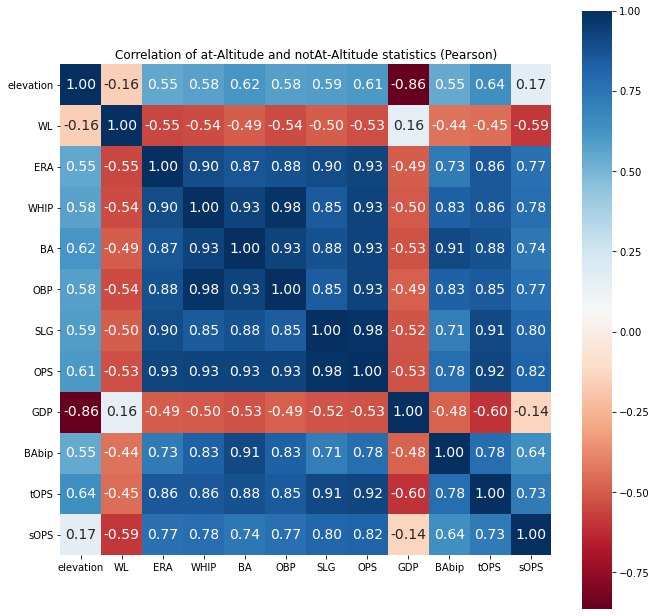

In [12]:
corrPearson = allData.corr(method = 'pearson')
plt.figure(figsize=(11,11))
sns.heatmap(corrPearson, square = True, annot = True, fmt = '.2f', annot_kws = {'size': 14}, \
            cmap = 'RdBu')
plt.title('Correlation of at-Altitude and notAt-Altitude statistics (Pearson)')
plt.show()

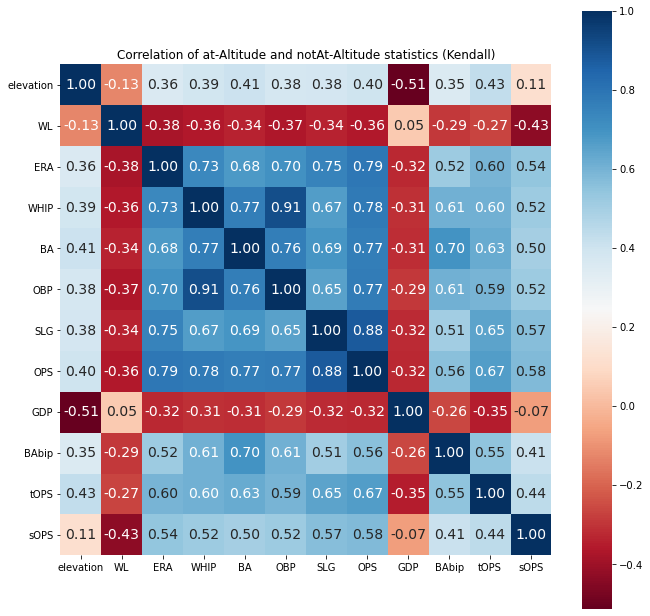

In [13]:
corrKendall = allData.corr(method = 'kendall')
plt.figure(figsize=(11,11))
sns.heatmap(corrKendall, square = True, annot = True, fmt = '.2f', annot_kws = {'size': 14}, \
            cmap = 'RdBu')
plt.title('Correlation of at-Altitude and notAt-Altitude statistics (Kendall)')
plt.show()

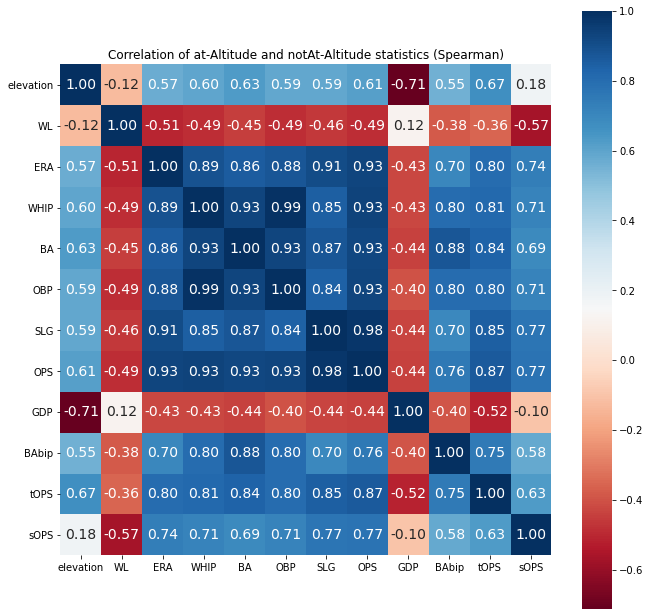

In [14]:
corrSpearman = allData.corr(method = 'spearman')
plt.figure(figsize=(11,11))
sns.heatmap(corrSpearman, square = True, annot = True, fmt = '.2f', annot_kws = {'size': 14}, \
            cmap = 'RdBu')
plt.title('Correlation of at-Altitude and notAt-Altitude statistics (Spearman)')
plt.show()

In [15]:
allData

,elevation,WL,ERA,WHIP,BA,OBP,SLG,OPS,GDP,BAbip,tOPS,sOPS
0,5183,0.500,5.82,1.706,0.314,0.377,0.471,0.848,1,0.345,118,90
1,5183,0.667,5.88,1.577,0.282,0.362,0.388,0.750,4,0.301,96,61
2,5183,1.000,3.33,1.148,0.219,0.299,0.375,0.674,2,0.243,81,50
3,5183,0.500,5.82,1.490,0.276,0.347,0.500,0.847,4,0.266,123,94
4,5183,0.429,6.10,1.581,0.304,0.366,0.528,0.894,9,0.317,146,88
...,...,...,...,...,...,...,...,...,...,...,...,...
489,25,0.568,3.38,1.164,0.243,0.292,0.370,0.662,49,0.294,93,88
490,25,0.617,3.43,1.149,0.231,0.293,0.367,0.660,70,0.289,95,82
491,25,0.580,3.94,1.227,0.241,0.308,0.400,0.708,63,0.294,101,93
492,25,0.506,4.21,1.269,0.246,0.313,0.429,0.743,57,0.293,105,106


In [16]:
temp = allData['elevation']
corrSpearmanWith = allData.corrwith(temp,method = 'spearman')
print('\nSpearman Correlation: ' )
print(corrSpearmanWith)
corrKendallWith = allData.corrwith(temp,method = 'kendall')
print('\nKendall Correlation: ' )
print(corrKendallWith)
corrPearsonWith = allData.corrwith(temp,method = 'pearson')
print('\nPearson Correlation: ' )
print(corrPearsonWith)

df_concat = p.concat((corrSpearmanWith, corrKendallWith),axis=1)
df_concat = p.concat((df_concat, corrPearsonWith),axis=1)
df_concat['mean'] = df_concat.mean(axis=1)
print(df_concat)


Spearman Correlation: 
elevation    1.000000
WL          -0.124644
ERA          0.565654
WHIP         0.596585
BA           0.627262
OBP          0.591575
SLG          0.587890
OPS          0.612241
GDP         -0.712047
BAbip        0.552402
tOPS         0.665642
sOPS         0.179542
dtype: float64

Kendall Correlation: 
elevation    1.000000
WL          -0.092010
ERA          0.422426
WHIP         0.445075
BA           0.469593
OBP          0.443313
SLG          0.439963
OPS          0.457584
GDP         -0.514146
BAbip        0.411923
tOPS         0.511499
sOPS         0.139354
dtype: float64

Pearson Correlation: 
elevation    1.000000
WL          -0.163100
ERA          0.549177
WHIP         0.575312
BA           0.616378
OBP          0.579162
SLG          0.588063
OPS          0.605967
GDP         -0.863528
BAbip        0.548125
tOPS         0.638117
sOPS         0.165391
dtype: float64
                  0         1         0      mean
elevation  1.000000  1.000000  1.000000  1.

<AxesSubplot:xlabel='elevation'>

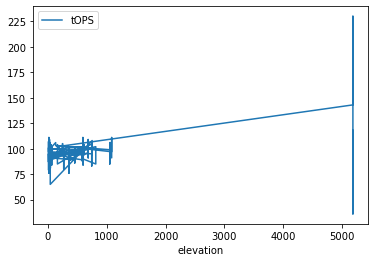

In [17]:
allData.plot(x='elevation', y='tOPS')

# Predicting elevation based on statistics using multi layer neural network

In [18]:
# Preparing the data set by converting all non-colorado based games
# vs colorado based games into binary representation

#1 = true, 0 = false
allData['atAltitude'] = np.where(allData['elevation'] == 5183, 1, 0)
allData


,elevation,WL,ERA,WHIP,BA,OBP,SLG,OPS,GDP,BAbip,tOPS,sOPS,atAltitude
0,5183,0.500,5.82,1.706,0.314,0.377,0.471,0.848,1,0.345,118,90,1
1,5183,0.667,5.88,1.577,0.282,0.362,0.388,0.750,4,0.301,96,61,1
2,5183,1.000,3.33,1.148,0.219,0.299,0.375,0.674,2,0.243,81,50,1
3,5183,0.500,5.82,1.490,0.276,0.347,0.500,0.847,4,0.266,123,94,1
4,5183,0.429,6.10,1.581,0.304,0.366,0.528,0.894,9,0.317,146,88,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
489,25,0.568,3.38,1.164,0.243,0.292,0.370,0.662,49,0.294,93,88,0
490,25,0.617,3.43,1.149,0.231,0.293,0.367,0.660,70,0.289,95,82,0
491,25,0.580,3.94,1.227,0.241,0.308,0.400,0.708,63,0.294,101,93,0
492,25,0.506,4.21,1.269,0.246,0.313,0.429,0.743,57,0.293,105,106,0


In [19]:
# Split train and test data
train, test = train_test_split(allData, test_size = 0.3, random_state = 12)
print("Train data shape: ", train.shape)
print("Test data shape: ", test.shape)

Train data shape:  (691, 13)
Test data shape:  (297, 13)


In [20]:
# Removing elevation data from data set
train_elevation = train['elevation']
test_elevation = test['elevation']
train_data = train.iloc[:, 1:]
test_data = test.iloc[:, 1:]

print("Train data shape: ", train_data.shape)
print("Test data shape: ", test_data.shape)
train_data

Train data shape:  (691, 12)
Test data shape:  (297, 12)


,WL,ERA,WHIP,BA,OBP,SLG,OPS,GDP,BAbip,tOPS,sOPS,atAltitude
227,0.556,5.76,1.556,0.300,0.361,0.487,0.848,7,0.340,151,116,1
339,0.457,4.32,1.412,0.273,0.336,0.433,0.769,62,0.316,96,118,0
398,0.571,3.88,1.475,0.296,0.341,0.424,0.765,5,0.366,122,89,1
319,0.250,6.55,1.758,0.303,0.390,0.492,0.882,3,0.340,142,94,1
403,1.000,2.33,0.852,0.194,0.240,0.327,0.567,1,0.222,61,31,1
...,...,...,...,...,...,...,...,...,...,...,...,...
241,0.667,6.23,1.269,0.255,0.306,0.449,0.755,2,0.304,98,85,1
253,0.333,5.04,1.520,0.263,0.342,0.465,0.807,2,0.282,120,104,1
390,0.444,5.21,1.447,0.275,0.343,0.508,0.851,6,0.319,135,95,1
173,0.543,3.11,1.195,0.241,0.299,0.351,0.650,54,0.284,91,81,0


In [21]:
#Isolating the atAltitude variable and the rest of the statistics
train_x = train_data.iloc[:, :-1]
train_x = MinMaxScaler().fit_transform(train_x)
test_x = test_data.iloc[:, :-1]
test_x = MinMaxScaler().fit_transform(test_x)
print("Train data shape: ", train_x.shape)
print("Test data shape: ", test_x.shape)

train_y = train_data.iloc[:,-1:]
test_y = test_data.iloc[:, -1:]
print("Train_y data shape: ", train_y.shape)
print("Test_y data shape: ", test_y.shape)


Train data shape:  (691, 11)
Test data shape:  (297, 11)
Train_y data shape:  (691, 1)
Test_y data shape:  (297, 1)


In [22]:
#ann_mlp def coded by Denver but altered to find the most accurate classfications
def ann_mlp(i, j):
    print("===========Data Summary===========")
    print("Training Data :", train_x.shape)
    print("Testing Data :", test_x.shape)

    X = tf.placeholder(tf.float32, [None,11])
    Y = tf.placeholder(tf.float32, [None, 1])

    # input
    W1 = tf.Variable(tf.random_normal([11,i], seed=0), name='weight1')
    b1 = tf.Variable(tf.random_normal([i], seed=0), name='bias1')
    layer1 = tf.nn.sigmoid(tf.matmul(X,W1) + b1)

    # hidden1
    W2 = tf.Variable(tf.random_normal([i,i], seed=0), name='weight2')
    b2 = tf.Variable(tf.random_normal([i], seed=0), name='bias2')
    layer2 = tf.nn.sigmoid(tf.matmul(layer1,W2) + b2)

    # hidden2
    W3 = tf.Variable(tf.random_normal([i,j], seed=0), name='weight3')
    b3 = tf.Variable(tf.random_normal([j], seed=0), name='bias3')
    layer3 = tf.nn.sigmoid(tf.matmul(layer2,W3) + b3)

    # output
    W4 = tf.Variable(tf.random_normal([j,1], seed=0), name='weight4')
    b4 = tf.Variable(tf.random_normal([1], seed=0), name='bias4')
    logits = tf.matmul(layer3,W4) + b4
    hypothesis = tf.nn.sigmoid(logits)

    cost_i = tf.nn.sigmoid_cross_entropy_with_logits(logits=logits,labels=Y)
    cost = tf.reduce_mean(cost_i)

    train = tf.train.GradientDescentOptimizer(learning_rate=0.001).minimize(cost)

    prediction = tf.cast(hypothesis > 0.5, dtype=tf.float32)
    correct_prediction = tf.equal(prediction, Y) 
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, dtype=tf.float32))

    print("\n============Processing============")
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for step in range(10001):
            sess.run(train, feed_dict={X: train_x, Y: train_y})
            if step % 1000 == 0:
                loss, acc = sess.run([cost, accuracy], feed_dict={X: train_x, Y: train_y})
                print("Step: {:5}\tLoss: {:.3f}\tAcc: {:.2%}".format(step, loss, acc))

        train_acc = sess.run(accuracy, feed_dict={X: train_x, Y: train_y})
        test_acc,test_predict,test_correct = sess.run([accuracy,prediction,correct_prediction], feed_dict={X: test_x, Y: test_y})
        
        print("\n============Results============")
        print("Model Prediction =", train_acc)
        print("Test Prediction =", test_acc)
        
        return train_acc,test_acc

In [23]:
ann_mlp_train_acc, ann_mlp_test_acc = ann_mlp(20,50)

===========Data Summary===========
Training Data : (691, 11)
Testing Data : (297, 11)

============Processing============


2021-11-29 20:02:53.906117: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Step:     0	Loss: 1.593	Acc: 49.93%
Step:  1000	Loss: 0.641	Acc: 82.05%
Step:  2000	Loss: 0.597	Acc: 89.15%
Step:  3000	Loss: 0.548	Acc: 90.45%
Step:  4000	Loss: 0.499	Acc: 91.75%
Step:  5000	Loss: 0.452	Acc: 92.04%
Step:  6000	Loss: 0.409	Acc: 92.76%
Step:  7000	Loss: 0.371	Acc: 93.34%
Step:  8000	Loss: 0.337	Acc: 94.07%
Step:  9000	Loss: 0.308	Acc: 94.50%
Step: 10000	Loss: 0.282	Acc: 94.36%

============Results============
Model Prediction = 0.94356006
Test Prediction = 0.959596


In [24]:
ann_mlp_train_acc, ann_mlp_test_acc = ann_mlp(40,50)

===========Data Summary===========
Training Data : (691, 11)
Testing Data : (297, 11)

============Processing============
Step:     0	Loss: 0.669	Acc: 51.81%
Step:  1000	Loss: 0.511	Acc: 95.66%
Step:  2000	Loss: 0.415	Acc: 96.24%
Step:  3000	Loss: 0.347	Acc: 96.38%
Step:  4000	Loss: 0.302	Acc: 96.38%
Step:  5000	Loss: 0.272	Acc: 96.38%
Step:  6000	Loss: 0.248	Acc: 96.53%
Step:  7000	Loss: 0.230	Acc: 96.53%
Step:  8000	Loss: 0.216	Acc: 96.53%
Step:  9000	Loss: 0.204	Acc: 96.38%
Step: 10000	Loss: 0.194	Acc: 96.38%

============Results============
Model Prediction = 0.9638206
Test Prediction = 0.96633


In [ ]:
ann_mlp_train_acc, ann_mlp_test_acc = ann_mlp(60,60)

===========Data Summary===========
Training Data : (691, 11)
Testing Data : (297, 11)

============Processing============
Step:     0	Loss: 1.025	Acc: 49.93%
Step:  1000	Loss: 0.522	Acc: 90.88%
Step:  2000	Loss: 0.436	Acc: 93.78%
Step:  3000	Loss: 0.375	Acc: 94.36%
Step:  4000	Loss: 0.328	Acc: 95.66%
Step:  5000	Loss: 0.291	Acc: 96.67%
Step:  6000	Loss: 0.260	Acc: 96.82%


### The results of this neural network show that it is entirely possible to determine whether a game was played at altitude or not based on the team statistics for that game.